In [ ]:
# Import libraries
import os
import keras
import pickle
import numpy as np
# Get a ResNet50 model
def resnet50_model(classes=1000, *args, **kwargs):
    # Load a model if we have saved one
    if(os.path.isfile('/content/drive/MyDrive/resnet_50.h5') == True):
        return keras.models.load_model('/content/drive/MyDrive/resnet_50.h5')
    # Create an input layer 
    input = keras.layers.Input(shape=(None, None, 3))
    # Create output layers
    output = keras.layers.ZeroPadding2D(padding=3, name='padding_conv1')(input)
    output = keras.layers.Conv2D(64, (7, 7), strides=(2, 2), use_bias=False, name='conv1')(output)
    output = keras.layers.BatchNormalization(axis=3, epsilon=1e-5, name='bn_conv1')(output)
    output = keras.layers.Activation('relu', name='conv1_relu')(output)
    output = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='pool1')(output)
    output = conv_block(output, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    output = identity_block(output, 3, [64, 64, 256], stage=2, block='b')
    output = identity_block(output, 3, [64, 64, 256], stage=2, block='c')
    output = conv_block(output, 3, [128, 128, 512], stage=3, block='a')
    output = identity_block(output, 3, [128, 128, 512], stage=3, block='b')
    output = identity_block(output, 3, [128, 128, 512], stage=3, block='c')
    output = identity_block(output, 3, [128, 128, 512], stage=3, block='d')
    output = conv_block(output, 3, [256, 256, 1024], stage=4, block='a')
    output = identity_block(output, 3, [256, 256, 1024], stage=4, block='b')
    output = identity_block(output, 3, [256, 256, 1024], stage=4, block='c')
    output = identity_block(output, 3, [256, 256, 1024], stage=4, block='d')
    output = identity_block(output, 3, [256, 256, 1024], stage=4, block='e')
    output = identity_block(output, 3, [256, 256, 1024], stage=4, block='f')
    output = conv_block(output, 3, [512, 512, 2048], stage=5, block='a')
    output = identity_block(output, 3, [512, 512, 2048], stage=5, block='b')
    output = identity_block(output, 3, [512, 512, 2048], stage=5, block='c')
    output = keras.layers.GlobalAveragePooling2D(name='pool5')(output)
    output = keras.layers.Dense(classes, activation='softmax', name='fc1000')(output)
    # Create a model from input layer and output layers
    model = keras.models.Model(inputs=input, outputs=output, *args, **kwargs)
    # Print model
    print()
    print(model.summary(), '\n')
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.adam(lr=0.01, clipnorm=0.001), metrics=['accuracy'])
    # Return a model
    return model
# Create an identity block
def identity_block(input, kernel_size, filters, stage, block):
    
    # Variables
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    # Create layers
    output = keras.layers.Conv2D(filters1, (1, 1), kernel_initializer='he_normal', name=conv_name_base + '2a')(input)
    output = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.Conv2D(filters2, kernel_size, padding='same', kernel_initializer='he_normal', name=conv_name_base + '2b')(output)
    output = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.Conv2D(filters3, (1, 1), kernel_initializer='he_normal', name=conv_name_base + '2c')(output)
    output = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(output)
    output = keras.layers.add([output, input])
    output = keras.layers.Activation('relu')(output)
    # Return a block
    return output
# Create a convolution block
def conv_block(input, kernel_size, filters, stage, block, strides=(2, 2)):
    # Variables
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    # Create block layers
    output = keras.layers.Conv2D(filters1, (1, 1), strides=strides, kernel_initializer='he_normal', name=conv_name_base + '2a')(input)
    output = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.Conv2D(filters2, kernel_size, padding='same', kernel_initializer='he_normal', name=conv_name_base + '2b')(output)
    output = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.Conv2D(filters3, (1, 1), kernel_initializer='he_normal', name=conv_name_base + '2c')(output)
    output = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(output)
    shortcut = keras.layers.Conv2D(filters3, (1, 1), strides=strides, kernel_initializer='he_normal', name=conv_name_base + '1')(input)
    shortcut = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '1')(shortcut)
    output = keras.layers.add([output, shortcut])
    output = keras.layers.Activation('relu')(output)
    # Return a block
    return output



In [ ]:
# Train a model
def train():
    # Variables, 25 epochs so far
    epochs = 50
    batch_size = 3
    train_samples = 10 * 1 # 10 categories with 5000 images in each category
    validation_samples = 10 * 1 # 10 categories with 1000 images in each category
    img_width, img_height = 224, 224
    # Get the model (10 categories)
    model = resnet50_model(10)
    # Create a data generator for training
    train_data_generator = keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255, 
        shear_range=0.2, 
        zoom_range=0.2, 
        horizontal_flip=True)
    # Create a data generator for validation
    validation_data_generator = keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2, 
        horizontal_flip=True)
    # Create a train generator
    train_generator = train_data_generator.flow_from_directory( 
        '/content/drive/MyDrive/prepro/clahee/train', 
        target_size=(img_width, img_height), 
        batch_size=batch_size,
        color_mode='rgb',
        shuffle=True,
        class_mode='categorical')
    # Create a test generator
    validation_generator = validation_data_generator.flow_from_directory( 
        '/content/drive/MyDrive/prepro/clahee/test', 
        target_size=(img_width, img_height), 
        batch_size=batch_size,
        color_mode='rgb',
        shuffle=True,
        class_mode='categorical')
    # Start training, fit the model
    history=model.fit_generator( 
        train_generator, 
        steps_per_epoch=train_samples // batch_size, 
        validation_data=validation_generator, 
        validation_steps=validation_samples // batch_size,
        epochs=epochs)
    # Save model to disk
    model.save('/content/drive/MyDrive/resnet_50.h5')
    print('Saved model to disk!')
    # Get labels
    labels = train_generator.class_indices
    # Invert labels
    classes = {}
    for key, value in labels.items():
        classes[value] = key.capitalize()
    # Save classes to file
    with open('/content/drive/MyDrive/classes.pkl', 'wb') as file:
        pickle.dump(classes, file)
    print('Saved classes to disk!')

In [ ]:
# The main entry point for this module
def main():
    # Train a model
    train()
# Tell python to run main method
if __name__ == '__main__': main()

Found 49 images belonging to 2 classes.
Found 31 images belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


3/3 [==============================] - 10s 3s/step - loss: 0.0328 - accuracy: 1.0000 - val_loss: 0.7193 - val_accuracy: 0.5556
Epoch 2/50
3/3 [==============================] - 6s 2s/step - loss: 0.2044 - accuracy: 0.8889 - val_loss: 0.7408 - val_accuracy: 0.5556
Epoch 3/50
3/3 [==============================] - 6s 2s/step - loss: 0.1850 - accuracy: 0.8889 - val_loss: 1.2259 - val_accuracy: 0.5556
Epoch 4/50
3/3 [==============================] - 6s 2s/step - loss: 0.0863 - accuracy: 1.0000 - val_loss: 0.9392 - val_accuracy: 0.4444
Epoch 5/50
3/3 [==============================] - 7s 2s/step - loss: 0.0769 - accuracy: 1.0000 - val_loss: 1.2182 - val_accuracy: 0.5556
Epoch 6/50
3/3 [==============================] - 5s 2s/step - loss: 0.7363 - accuracy: 0.5714 - val_loss: 0.4394 - val_accuracy: 0.6667
Epoch 7/50
3/3 [==============================] - 6s 2s/step - loss: 0.1226 - accuracy: 0.8889 - val_loss: 1.4204 - val_accuracy: 0.4444
Epoch 8/50
3/3 [==============================] - 6

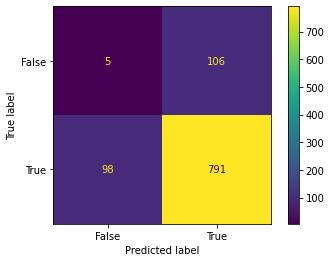

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = numpy.random.binomial(1,.9,size = 1000)
predicted = numpy.random.binomial(1,.9,size = 1000)

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()